In [0]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix

In [258]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Read in and basic overview

In [259]:
# Read csv dataset
path_dataset = 'gdrive/My Drive/CS109BProject/data/Capital_Projects.csv'
df = pd.read_csv(path_dataset)
#print(df.shape)
df.replace('', np.nan, inplace=True)
# Drop nan values for the following columns
df = df.dropna(subset=['Budget Forecast', 'Total Budget Changes',
                       'Forecast Completion', 'Total Schedule Changes'], how='all')
# Only take budget forecast for positive values
df = df[df['Budget Forecast'] >= 0]
# Reset index to eliminate completely missing rows from the dataframe
df.reset_index(drop=True, inplace=True)
# Keep only last row of each project
df = df.groupby('PID').tail(1)
df.describe(include='all')

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes
count,367,367.000000,367,364,367,181,367,283,367,356,3.670000e+02,3.140000e+02,3.140000e+02,360,307.000000,309.000000
unique,4,NaN,366,327,22,19,12,30,5,307,NaN,NaN,NaN,288,NaN,NaN
top,09/01/2019 12:00:00 AM,NaN,FUEL TANK REPLACEMENT,Design and construction of a new school,Streets and Roadways,Brooklyn,DDC,DEP,Construction,05/04/2016,NaN,NaN,NaN,09/03/2021,NaN,NaN
freq,284,NaN,2,31,81,50,168,113,172,7,NaN,NaN,NaN,17,NaN,NaN
mean,NaN,657.457766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.118842e+08,1.872939e+06,1.403277e+07,NaN,53.592834,450.158576
std,NaN,259.175801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.514155e+08,3.595631e+07,7.722460e+07,NaN,216.195431,636.282607
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,-2.664272e+08,-2.919002e+08,NaN,-1462.000000,-1462.000000
25%,NaN,505.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.552250e+07,0.000000e+00,-3.025000e+04,NaN,0.000000,0.000000
50%,NaN,680.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.369206e+07,0.000000e+00,1.472004e+06,NaN,0.000000,297.000000
75%,NaN,867.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.980109e+07,8.537500e+05,1.994925e+07,NaN,78.000000,816.000000


## Regression Model

In [260]:
#### (1) #### CHANGE object to datetime64[ns] for columns with dates, drop NaNs
df['Forecast Completion'] =pd.to_datetime(df['Forecast Completion'], format='%m/%d/%Y', exact=False)
df['Date Reported As Of'] = pd.to_datetime(df['Date Reported As Of'],format='%m/%d/%Y', exact=False)
df['Design Start'] = pd.to_datetime(df['Design Start'], format='%m/%d/%Y', exact=False)
date_reported_min = min(df['Date Reported As Of'])
date_min = min([min(df['Date Reported As Of']), min(df['Design Start']), min(df['Forecast Completion'])])
print(f'Minimum Date: {date_min}')
print(f'Date Reported Minimum: {date_reported_min}')
df.dtypes

Minimum Date: 1993-08-02 00:00:00
Date Reported Minimum: 2018-03-01 00:00:00


Date Reported As Of        datetime64[ns]
PID                                 int64
Project Name                       object
Description                        object
Category                           object
Borough                            object
Managing Agency                    object
Client Agency                      object
Current Phase                      object
Design Start               datetime64[ns]
Budget Forecast                   float64
Latest Budget Changes             float64
Total Budget Changes              float64
Forecast Completion        datetime64[ns]
Latest Schedule Changes           float64
Total Schedule Changes            float64
dtype: object

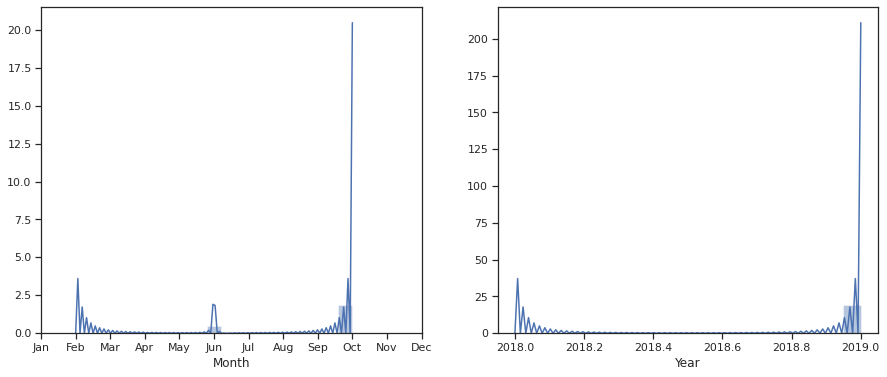

In [261]:
#### (2) #### Extract MONTH and YEAR from Date Reported
df['Month'] = df['Date Reported As Of'].dt.month
df['Year'] = df['Date Reported As Of'].dt.year
month_ticks = {0:'Jan', 1:'Feb',2:'Mar',3:'Apr',4:'May',5:'Jun',6:'Jul',7:'Aug',8:'Sep',9:'Oct',10:'Nov',11:'Dec'}
fig, axes = plt.subplots(1,2, figsize=(15,6))
sns.distplot(df['Month'], ax=axes[0])
axes[0].set_xticks(list(month_ticks.keys()))
axes[0].set_xticklabels(list(month_ticks.values()))
sns.distplot(df['Year'],ax=axes[1])
plt.show()

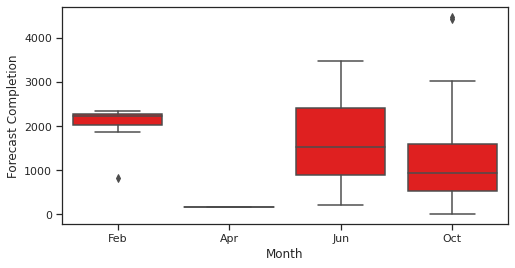

In [262]:
plt_df = df.copy()
plt_df['Forecast Completion'] = pd.to_numeric((plt_df['Forecast Completion'].copy() - min(df['Forecast Completion']))/pd.Timedelta(days=1))
plt.figure(figsize=(8,4))
sns.boxplot(
    data=plt_df,
    x='Month',
    y='Forecast Completion',
    color='red')

plt.xticks([0,1,2,3],['Feb', 'Apr', 'Jun','Oct'])
plt.show()

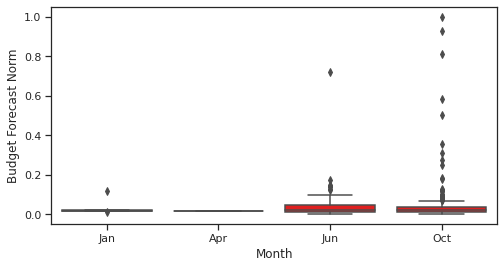

In [263]:
plt_df['Budget Forecast Norm'] = (plt_df['Budget Forecast'] - min(plt_df['Budget Forecast']))/(max(plt_df['Budget Forecast']) - min(plt_df['Budget Forecast']))
plt.figure(figsize=(8,4))
sns.boxplot(
    data=plt_df,
    x='Month',
    y='Budget Forecast Norm',
    color='red')

plt.xticks([0,1,2,3],['Jan', 'Apr', 'Jun','Oct'])
plt.show()

Max Project Duration: 9736 days 00:00:00 
 Min Project Duration: 656 days 00:00:00 


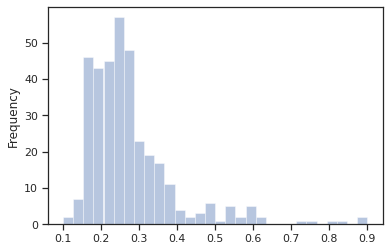

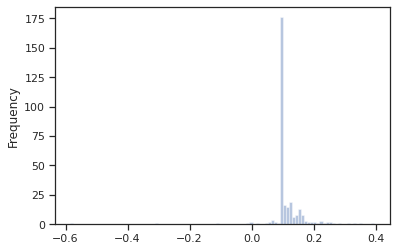

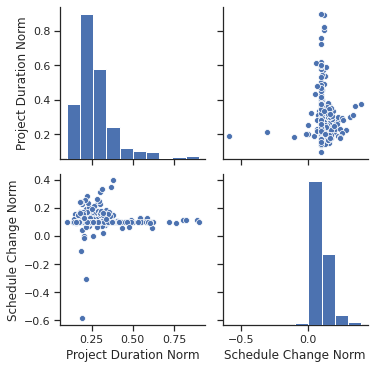

In [264]:
### (a) Schedule Change Norm ===>  Change Normalized to Project Duration of each project
### (b) Project Duration Norm ===> Normalized over all projects (to normalize across big and small projects)
df['Project Duration'] = df['Forecast Completion'] - df['Design Start']
df['Schedule Change Norm'] = (0.9-0.1)*df['Latest Schedule Changes']/(df['Project Duration']/pd.Timedelta(days=1)) + 0.1
max_project_duration = max(df['Project Duration'])
min_project_duration = min(df['Project Duration'])
df['Project Duration Norm'] = (0.9 - 0.1) * (df['Project Duration'] - min_project_duration) / (max_project_duration - min_project_duration) + 0.1
print(f'Max Project Duration: {max_project_duration} \n Min Project Duration: {min_project_duration} ')
df.head()
#df[['Schedule Change Norm', 'Project Duration Norm']].plot.hist(bins=30, alpha=0.4)
df['Project Duration Norm'].plot.hist(bins=30, alpha=0.4)
plt.show()
df['Schedule Change Norm'].plot.hist(bins=100, alpha=0.4)
plt.show()
#(df['Schedule Change Norm'].ravel())
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df[['Project Duration Norm', 'Schedule Change Norm']])

Max Budget: 2449621616.0 
 Min Budget: 0.0
Minimum Budget Change Norm: -2.9434477574857567


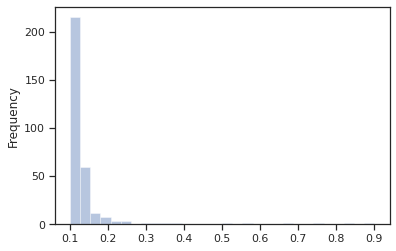

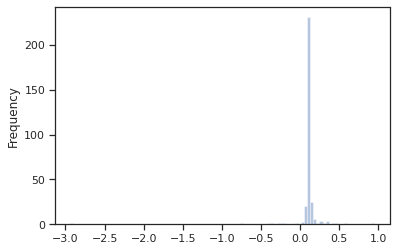

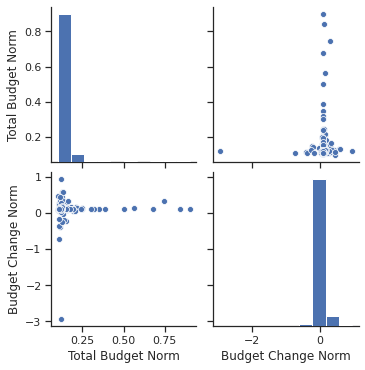

In [265]:
### (a) Budget Change Norm ===>  Budget Change Normalized to Final Budget of each project
### (b) Total Budget Norm ===> Budget Forecast Normalized through all projects
df['Budget Change Norm'] = (0.9-0.1)*df['Latest Budget Changes']/df['Budget Forecast'] + 0.1
max_budget_final = max(df['Budget Forecast'])
min_budget_final = min(df['Budget Forecast'])
df['Total Budget Norm'] = (0.9-0.1)*(df['Budget Forecast'] - min_budget_final)/(max_budget_final - min_budget_final) + 0.1
print(f'Max Budget: {max_budget_final} \n Min Budget: {min_budget_final}')

# Remove outliers
df = df[df['Budget Change Norm'] >= -30]
min_budget_norm = min(df['Budget Change Norm'])
print(f'Minimum Budget Change Norm: {min_budget_norm}')
df.dtypes

#df[['Schedule Change Norm', 'Project Duration Norm']].plot.hist(bins=12, alpha=0.4)
df['Total Budget Norm'].plot.hist(bins=30, alpha=0.4)
plt.show()
df['Budget Change Norm'].plot.hist(bins=100, alpha=0.4)
plt.show()
#(df['Schedule Change Norm'].ravel())
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df[['Total Budget Norm', 'Budget Change Norm']])

In [296]:
####  (4)  #### Handle Categorical Columns using dummy variables
categorical_columns = ['Category', 'Borough'] # not including Agencies nor Decription
nyc_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#### (5) #### Drop redundant or useless columns, and drop NaNs
drop_columns = ['Date Reported As Of', 'PID', 'Project Name', 'Description','Managing Agency', 
                'Client Agency', 'Design Start', 'Budget Forecast', 'Latest Budget Changes', 
                'Latest Schedule Changes', 'Total Schedule Changes', 'Total Budget Changes', 
                'Forecast Completion', 'Year', 'Month', 'Project Duration', 'Current Phase']
nyc_df = nyc_df.drop(drop_columns, axis=1)
nyc_df.describe(include='all')

,Schedule Change Norm,Project Duration Norm,Budget Change Norm,Total Budget Norm,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,"Category_Health and Hospitals, IT",Category_IT,Category_Industrial Development,"Category_Industrial Development, Parks","Category_Industrial Development, Streets and Roadways",Category_Libraries,Category_Other Government Facilities,Category_Parks,"Category_Parks, Streets and Roadways",Category_Public Safety and Criminal Justice,Category_Sanitation,Category_Schools,Category_Sewers,Category_Social Services,Category_Streets and Roadways,Category_Wastewater Treatment,Category_Water Supply,"Borough_Bronx, Manhattan",Borough_Brooklyn,"Borough_Brooklyn, Queens",Borough_Carmel,Borough_Citywide,Borough_Manhattan,"Borough_Manhattan, Bronx","Borough_Manhattan, Staten Island","Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_Marlboro,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
count,300.000000,300.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,0.113154,0.285528,0.101344,0.140200,0.067524,0.057878,0.012862,0.016077,0.009646,0.006431,0.106109,0.003215,0.003215,0.009646,0.032154,0.028939,0.003215,0.045016,0.022508,0.086817,0.112540,0.003215,0.202572,0.077170,0.083601,0.003215,0.160772,0.003215,0.003215,0.032154,0.093248,0.006431,0.003215,0.003215,0.003215,0.003215,0.006431,0.003215,0.003215,0.109325,0.045016,0.006431,0.006431
std,0.067004,0.126230,0.204141,0.088563,0.251332,0.233889,0.112860,0.125975,0.097898,0.080063,0.308474,0.056705,0.056705,0.097898,0.176694,0.167905,0.056705,0.207674,0.148568,0.282020,0.316539,0.056705,0.402564,0.267292,0.277235,0.056705,0.367912,0.056705,0.056705,0.176694,0.291248,0.080063,0.056705,0.056705,0.056705,0.056705,0.080063,0.056705,0.056705,0.312549,0.207674,0.080063,0.080063
min,-0.585982,0.100000,-2.943448,0.100721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.100000,0.205529,0.100000,0.112702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.100000,0.255947,0.100000,0.119256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.122140,0.321322,0.112377,0.132607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.395839,0.900000,0.947947,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.

In [0]:
nyc_df = nyc_df.dropna()
nyc_train, nyc_test = train_test_split(nyc_df, test_size=.2, random_state=90)

In [298]:
nyc_train.head()

,Schedule Change Norm,Project Duration Norm,Budget Change Norm,Total Budget Norm,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,"Category_Health and Hospitals, IT",Category_IT,Category_Industrial Development,"Category_Industrial Development, Parks","Category_Industrial Development, Streets and Roadways",Category_Libraries,Category_Other Government Facilities,Category_Parks,"Category_Parks, Streets and Roadways",Category_Public Safety and Criminal Justice,Category_Sanitation,Category_Schools,Category_Sewers,Category_Social Services,Category_Streets and Roadways,Category_Wastewater Treatment,Category_Water Supply,"Borough_Bronx, Manhattan",Borough_Brooklyn,"Borough_Brooklyn, Queens",Borough_Carmel,Borough_Citywide,Borough_Manhattan,"Borough_Manhattan, Bronx","Borough_Manhattan, Staten Island","Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_Marlboro,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
1709,0.146398,0.186520,0.100000,0.120680,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1196,0.113208,0.266344,0.123780,0.122654,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1826,0.100000,0.265022,0.094549,0.502124,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
901,0.100000,0.368194,0.100008,0.118449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
711,0.100000,0.220352,0.100000,0.121980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


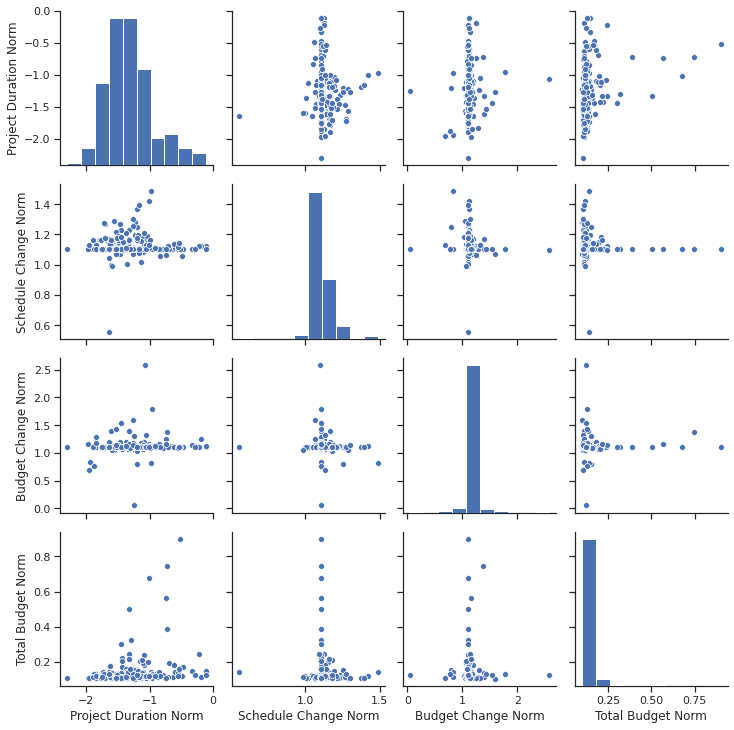

In [299]:
qual_columns = ['Project Duration Norm',	'Schedule Change Norm',
                'Budget Change Norm',	'Total Budget Norm']	
#scatter_matrix(nyc_train[qual_columns].sample(frac=0.4, axis=0),alpha=0.5, figsize=(25,20));
plt_df = nyc_train.copy()
plt_df['Budget Change Norm'] = np.exp(plt_df['Budget Change Norm'])
plt_df['Total Budget Norm'] = np.abs(plt_df['Total Budget Norm'])
plt_df['Schedule Change Norm'] = np.exp(plt_df['Schedule Change Norm'])
plt_df['Project Duration Norm'] = np.log(plt_df['Project Duration Norm'])
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(plt_df[qual_columns])
#nyc_train = plt_df

In [300]:
nyc_train[qual_columns].corr()

,Project Duration Norm,Schedule Change Norm,Budget Change Norm,Total Budget Norm
Project Duration Norm,1.000000,0.013730,0.041648,0.261421
Schedule Change Norm,0.013730,1.000000,-0.036471,-0.054797
Budget Change Norm,0.041648,-0.036471,1.000000,0.031093
Total Budget Norm,0.261421,-0.054797,0.031093,1.000000


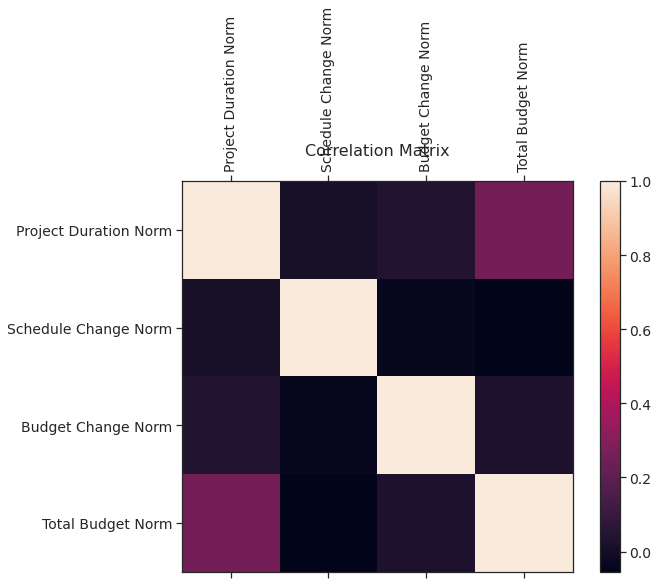

In [301]:
f = plt.figure(figsize=(10, 7))
plt.matshow(nyc_train[qual_columns].corr(), fignum=f.number)
plt.xticks(range(len(qual_columns)), qual_columns, fontsize=14, rotation=90)
plt.yticks(range(len(qual_columns)), qual_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [307]:
# Budget change
# 'Stage', 'Project Duration', 'Forecast Completion Norm', 'Schedule Change Norm',
# 'Final Budget', 'Budget Forecast Norm', 'Budget Change Norm'
nyc_train_trunc = nyc_train.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train = np.exp(nyc_train_trunc['Budget Change Norm'])
X_train = nyc_train_trunc.drop(['Budget Change Norm', 'Schedule Change Norm'], axis=1)
#X_train = nyc_train_trunc['Stage'].ravel().reshape(-1,1)
X_train['Total Budget Norm'] = np.log(X_train['Total Budget Norm'])
X_train['Project Duration Norm'] = np.log(X_train['Project Duration Norm'])
#X_train['Final Budget'] = np.log(X_train['Final Budget'])
#poly = PolynomialFeatures(interaction_only=True,include_bias = False)
#X_train = poly.fit_transform(X_train)
fitted_model = LinearRegression().fit(X_train, y_train)
fitted_model.score(X_train, y_train)

# Normalization or Standardization
# DateTime => numeric - (- 2013) 
# QQ plot (normal plot)

0.07325019522440201

In [308]:
X_train = sm.add_constant(X_train)
results = OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                 -0.102
Method:                 Least Squares   F-statistic:                    0.4181
Date:                Tue, 05 May 2020   Prob (F-statistic):              0.999
Time:                        17:41:51   Log-Likelihood:                 127.29
No. Observations:                 240   AIC:                            -176.6
Df Residuals:                     201   BIC:                            -40.83
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     1.0514      0.131      8.003      0.000       0.792       1.310
Project Duration Norm                                     0.0118      0.037      0.320      0.749      -0.061       0.085
Total Budget Norm                                        -0.0193      0.044     -0.436      0.663      -0.106       0.068
Category_Bridges                                          0.0245      0.103      0.237      0.813      -0.180       0.228
Category_Bridges, Streets and Roadways                    0.0713      0.099      0.719      0.473      -0.124       0.267
Category_Ferries                                          0.0334      0.148      0.226      0.821      -0.258       0.324
Category_Health and Hospitals                             0.0298      0.131      0.228      0.820      -0.228       0.287
Category_Health and Hospitals, IT                       -1.9e-16   4.39e-16     -0.433      0.665   -1.06e-15    6.75e-16
Category_IT                                            2.956e-16   5.78e-16      0.511      0.610   -8.45e-16    1.44e-15
Category_Industrial Development                           0.0286      0.096      0.299      0.765      -0.160       0.218
Category_Industrial Development, Parks                    0.0502      0.191      0.263      0.793      -0.326       0.427
Category_Industrial Development, Streets and Roadways     0.0616      0.183      0.336      0.737      -0.300       0.423
Category_Libraries                                        0.0299      0.143      0.209      0.835      -0.252       0.312
Category_Other Government Facilities                      0.0037      0.108      0.034      0.973      -0.209       0.217
Category_Parks                                            0.0311      0.108      0.288      0.773      -0.182       0.244
Category_Parks, Streets and Roadways                   1.468e-16   2.47e-16      0.595      0.552    -3.4e-16    6.33e-16
Category_Public Safety and Criminal Justice               0.0370      0.106      0.350      0.727      -0.172       0.245
Category_Sanitation                                       0.0202      0.111      0.182      0.856      -0.200       0.240
Category_Schools                                         -0.0052      0.098     -0.053      0.958      -0.198       0.188
Category_Sewers                                          -0.0045      0.097     -0.047      0.963      -0.195       0.186
Category_Social Services                                  0.0291      0.181      0.161      0.872      -0.327       0.385
Category_Streets and Roadways                             0.0520      0.093      0.556      0.579      -0.132       0.236
Category_Wastewater Treatment    

In [309]:
# Multi-collinearity
X_train_save = X_train.copy()
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X_train.values, i) 
               for i in range(X_train.shape[1])], 
               index=X_train.columns)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const                                                    171.142587
Project Duration Norm                                      1.961953
Total Budget Norm                                          1.840340
Category_Bridges                                           6.218066
Category_Bridges, Streets and Roadways                     6.432238
Category_Ferries                                           3.541233
Category_Health and Hospitals                              2.089874
Category_Health and Hospitals, IT                               NaN
Category_IT                                                     NaN
Category_Industrial Development                            9.094333
Category_Industrial Development, Parks                     1.500097
Category_Industrial Development, Streets and Roadways      1.380926
Category_Libraries                                         1.679266
Category_Other Government Facilities                       3.275022
Category_Parks                                  

In [310]:
# Remove multi-collinearity
# Transforms

X_train = X_train_save.copy()
drop_mc_columns = ['Category_Parks, Streets and Roadways', 'Category_IT', 'Category_Health and Hospitals, IT',]
X_train = X_train.drop(drop_mc_columns, axis=1)
results = OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                 -0.102
Method:                 Least Squares   F-statistic:                    0.4181
Date:                Tue, 05 May 2020   Prob (F-statistic):              0.999
Time:                        17:43:21   Log-Likelihood:                 127.29
No. Observations:                 240   AIC:                            -176.6
Df Residuals:                     201   BIC:                            -40.83
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     1.0514      0.131      8.003      0.000       0.792       1.310
Project Duration Norm                                     0.0118      0.037      0.320      0.749      -0.061       0.085
Total Budget Norm                                        -0.0193      0.044     -0.436      0.663      -0.106       0.068
Category_Bridges                                          0.0245      0.103      0.237      0.813      -0.180       0.228
Category_Bridges, Streets and Roadways                    0.0713      0.099      0.719      0.473      -0.124       0.267
Category_Ferries                                          0.0334      0.148      0.226      0.821      -0.258       0.324
Category_Health and Hospitals                             0.0298      0.131      0.228      0.820      -0.228       0.287
Category_Industrial Development                           0.0286      0.096      0.299      0.765      -0.160       0.218
Category_Industrial Development, Parks                    0.0502      0.191      0.263      0.793      -0.326       0.427
Category_Industrial Development, Streets and Roadways     0.0616      0.183      0.336      0.737      -0.300       0.423
Category_Libraries                                        0.0299      0.143      0.209      0.835      -0.252       0.312
Category_Other Government Facilities                      0.0037      0.108      0.034      0.973      -0.209       0.217
Category_Parks                                            0.0311      0.108      0.288      0.773      -0.182       0.244
Category_Public Safety and Criminal Justice               0.0370      0.106      0.350      0.727      -0.172       0.245
Category_Sanitation                                       0.0202      0.111      0.182      0.856      -0.200       0.240
Category_Schools                                         -0.0052      0.098     -0.053      0.958      -0.198       0.188
Category_Sewers                                          -0.0045      0.097     -0.047      0.963      -0.195       0.186
Category_Social Services                                  0.0291      0.181      0.161      0.872      -0.327       0.385
Category_Streets and Roadways                             0.0520      0.093      0.556      0.579      -0.132       0.236
Category_Wastewater Treatment                            -0.0038      0.098     -0.039      0.969      -0.197       0.189
Category_Water Supply                                    -0.0011      0.100     -0.011      0.991      -0.198       0.196
Borough_Bronx, Manhattan                                  0.0051      0.164      0.031      0.975      -0.317       0.328
Borough_Brooklyn                 

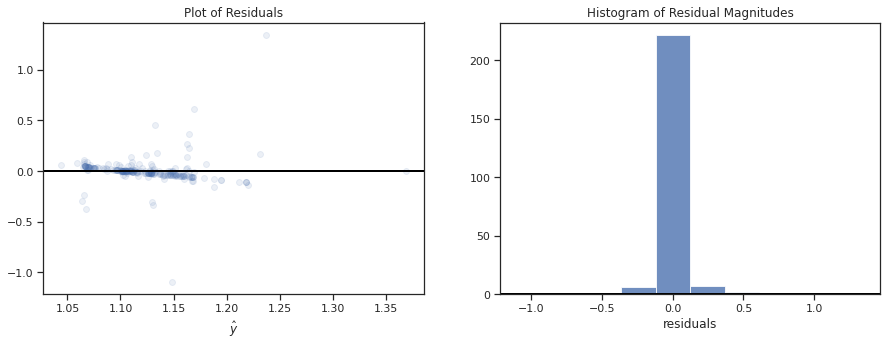

In [311]:
# Residual Plots
y_hat_train = results.predict()
residuals = (y_train - y_hat_train)
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter((y_hat_train), residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()


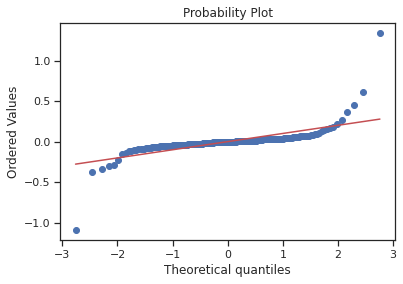

In [312]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

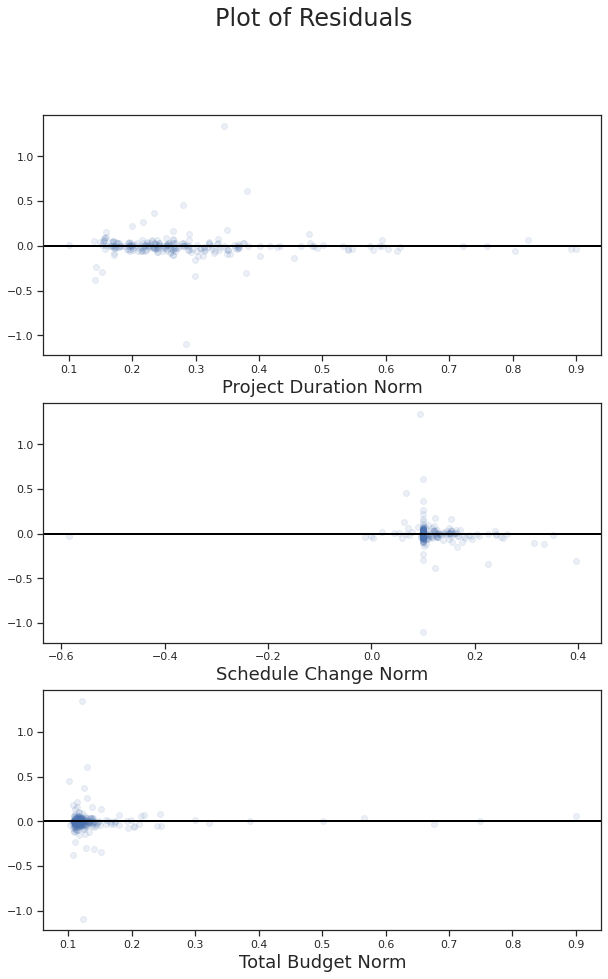

In [313]:
# Residual Plots
X_colms = ['Project Duration Norm','Schedule Change Norm','Total Budget Norm']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(3,1,figsize=(10,15))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()

In [316]:
# Schedule change
y_train = np.exp(nyc_train['Schedule Change Norm'])
X_train = nyc_train.drop(['Budget Change Norm', 'Schedule Change Norm'], axis=1)
X_train['Total Budget Norm'] = np.log(X_train['Total Budget Norm'])
X_train['Project Duration Norm'] = np.log(X_train['Project Duration Norm'])
drop_mc_columns = ['Category_Parks, Streets and Roadways', 'Category_IT', 'Category_Health and Hospitals, IT',]
X_train = X_train.drop(drop_mc_columns, axis=1)
fitted_model = LinearRegression().fit(X_train, y_train)
fitted_model.score(X_train, y_train)

0.1014390358949413

In [317]:
X_train = sm.add_constant(X_train)
results = OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Schedule Change Norm   R-squared:                       0.101
Model:                              OLS   Adj. R-squared:                 -0.068
Method:                   Least Squares   F-statistic:                    0.5971
Date:                  Tue, 05 May 2020   Prob (F-statistic):              0.970
Time:                          17:45:56   Log-Likelihood:                 316.87
No. Observations:                   240   AIC:                            -555.7
Df Residuals:                       201   BIC:                            -420.0
Df Model:                            38                                         
Covariance Type:              nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     1.0900      0.060     18.280      0.000       0.972       1.208
Project Duration Norm                                     0.0071      0.017      0.421      0.674      -0.026       0.040
Total Budget Norm                                        -0.0150      0.020     -0.749      0.455      -0.055       0.025
Category_Bridges                                          0.0448      0.047      0.954      0.341      -0.048       0.137
Category_Bridges, Streets and Roadways                   -0.0046      0.045     -0.101      0.920      -0.093       0.084
Category_Ferries                                          0.0189      0.067      0.282      0.778      -0.113       0.151
Category_Health and Hospitals                            -0.0094      0.059     -0.159      0.874      -0.126       0.107
Category_Industrial Development                          -0.0016      0.044     -0.036      0.972      -0.087       0.084
Category_Industrial Development, Parks                    0.0142      0.087      0.164      0.870      -0.157       0.185
Category_Industrial Development, Streets and Roadways    -0.0127      0.083     -0.153      0.878      -0.177       0.151
Category_Libraries                                        0.0110      0.065      0.170      0.865      -0.117       0.139
Category_Other Government Facilities                      0.0042      0.049      0.086      0.931      -0.092       0.101
Category_Parks                                            0.0130      0.049      0.265      0.791      -0.084       0.110
Category_Public Safety and Criminal Justice               0.0280      0.048      0.583      0.560      -0.067       0.123
Category_Sanitation                                       0.0055      0.051      0.110      0.913      -0.094       0.105
Category_Schools                                         -0.0045      0.044     -0.101      0.920      -0.092       0.083
Category_Sewers                                           0.0097      0.044      0.220      0.826      -0.077       0.096
Category_Social Services                                 -0.0073      0.082     -0.089      0.929      -0.169       0.154
Category_Streets and Roadways                             0.0421      0.042      0.992      0.322      -0.042       0.126
Category_Wastewater Treatment                             0.0148      0.044      0.333      0.739      -0.073       0.102
Category_Water Supply                                     0.0024      0.045      0.053      0.958      -0.087       0.092
Borough_Bronx, Manhattan                                 -0.0171      0.074     -0.231      0.818      -0.164       0.129
Borough_Bro

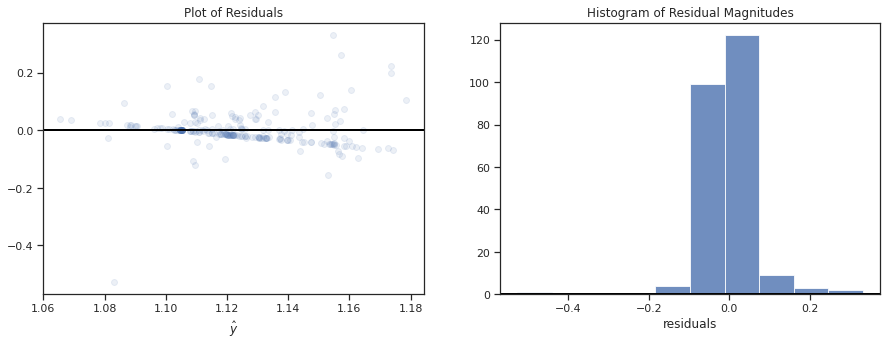

In [318]:
# Residual Plots
y_hat_train = results.predict()
residuals = y_train - y_hat_train
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

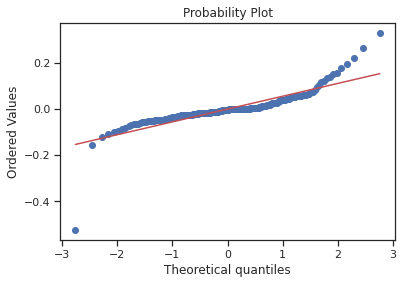

In [320]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()
plt.show()

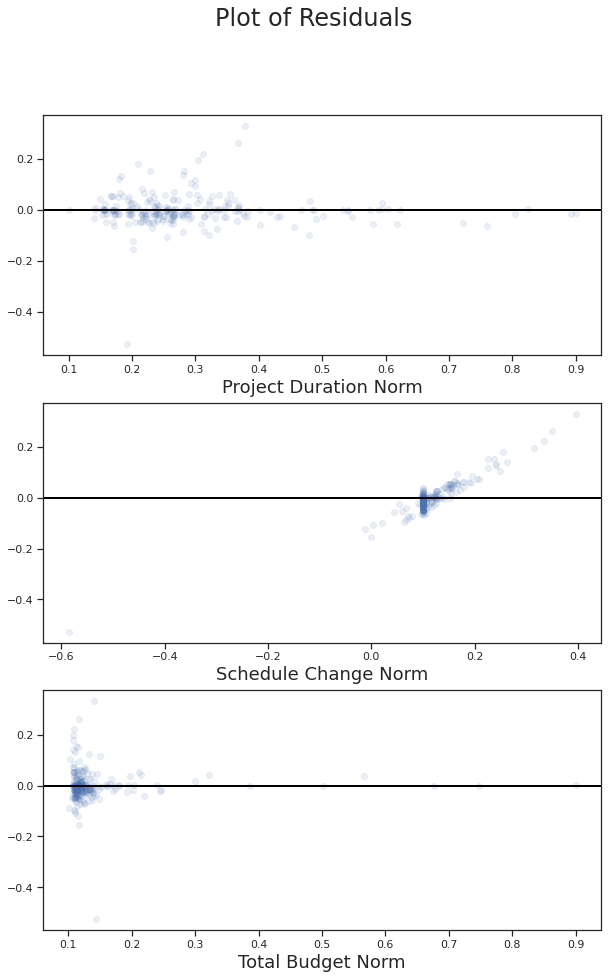

In [321]:
# Residual Plots
# Residual Plots
X_colms = ['Project Duration Norm','Schedule Change Norm','Total Budget Norm']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(3,1,figsize=(10,15))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()